# Mutual Fund Price Prediction

# Mary Donovan Martello

## The goal of this project was to design models to predict mutual fund return values and to identify the features that best predict those return values. This notebook uses a Linear Regression model and a LASSO Linear Regression model to predict the mutual fund price.

# Part 3:  Regression Models

In [2]:
# import libraries
from __future__ import print_function, division

%matplotlib inline

# import libraries

import numpy as np
import pandas as pd
import random
import yellowbrick
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Markdown, display

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso


from sklearn import metrics
from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score
from sklearn.pipeline import make_pipeline

#stop unnecessary warnings from printing to the screen
import warnings
warnings.simplefilter('ignore')

### This data source contains 25,000+ mutual funds with 125 features including general aspects (as total net assets, management company and size), portfolio indicators (as cash, stocks, bonds, and sectors), returns (as year-to-date, 2018-10) and financial ratios (as price/earnings, Treynor and Sharpe ratios, alpha, and beta).  The target variable it year-to-date return (ytd_return) of the mutual funds.

In [3]:
# Load data into a dataframe
# import file
mf = pd.read_csv('Mutual Funds.csv')


In [4]:
mf.head(2)

,fund_name,fund_extended_name,category,fund_family,net_assets,ytd_return,fund_yield,morningstar_rating,inception_date,investment,...,fund_sharpe_ratio_5years,category_sharpe_ratio_5years,fund_sharpe_ratio_10years,category_sharpe_ratio_10years,fund_treynor_ratio_3years,category_treynor_ratio_3years,fund_treynor_ratio_5years,category_treynor_ratio_5years,fund_treynor_ratio_10years,category_treynor_ratio_10years
0,AAAAX,DWS RREEF Real Assets Fund - Class A,World Allocation,DWS,530280000.0,12.79,1.43,3,2007-07-29,Blend,...,0.31,0.00,0.73,0.01,5.05,0.05,2.26,0.02,6.71,0.07
1,AAADX,Aberdeen Income Builder Fund Class A,Large Blend,Aberdeen,88840000.0,9.21,2.62,2,2011-12-29,Blend,...,0.62,0.01,0.97,0.01,11.55,0.11,6.91,0.08,12.77,0.14


### This notebook uses two datasets that were cleaned and prepared in the 1_EDA_Prep_Dimension notebook.  One of the datasets included PCA Components.  The other dataset includes the original features before PCA transformation.

In [3]:
pcaDf = pd.read_csv('pcaMFdf4.csv')

In [9]:
df = pd.read_csv('regMFdf2.csv')

**Create feature dataframes for modeling.**

In [5]:
# convert categorical data to numbers

#get the categorical data
cat_features = ['investment', 'size']
df_cat = pcaDf[cat_features]

# One Hot Encoding 
dfDumm = pd.get_dummies(df_cat)

# check the data
print(dfDumm.head(8))

   investment_Blend  investment_Growth  investment_Value  size_Large  \
0                 1                  0                 0           1   
1                 0                  1                 0           1   
2                 0                  1                 0           1   
3                 1                  0                 0           1   
4                 1                  0                 0           1   
5                 0                  1                 0           1   
6                 1                  0                 0           1   
7                 1                  0                 0           1   

   size_Medium  size_Small  
0            0           0  
1            0           0  
2            0           0  
3            0           0  
4            0           0  
5            0           0  
6            0           0  
7            0           0  


> Create separate dataframes/variables for the feature variables and the target variable 

In [6]:
# create a whole features dataset that can be used for train and validation data splitting
# here we will combine the numerical features and the dummie features together
dfNum = pcaDf.drop(['ytd_return', 'investment', 'size'], axis = 1)
X = pd.concat([dfNum, dfDumm], axis=1)
# create a whole target dataset that can be used for train and validation data splitting
y =  pcaDf['ytd_return']


### In the 2_Feature_Selection_and_Test_Subsets file, the subset of input features that produced the best score was Subset 3.

In [11]:
# create a subset of the df that can be used for train and validation data splitting

subset3 = df.loc[:, [
 'fund_return_1month',
 'category_return_1month',
 'fund_return_3months',
 'fund_return_1year',
 'category_return_1year',
 'fund_return_3years',
 'category_return_3years',
 'fund_return_5years',
 'category_return_5years',
 'fund_return_10years',
 'category_return_10years',
 'fund_return_2018',
 'category_return_2018',
 'fund_return_2017',
 'category_return_2017',
 'fund_return_2016',
 'category_return_2016',
 'fund_return_2015',
 'category_return_2015']]

# separate data into training and validation 
S3Train, S3Test, yTrain_S3, yTest_S3 = train_test_split(subset3, y, test_size =0.3, random_state=11)

# Instantiate the linear regression model using default parameters
olsS3 = LinearRegression()

# Fit the model with training data
olsS3.fit(S3Train, yTrain_S3)

# evaluate the baseline with the r-squared score
print(olsS3.score(S3Test, yTest_S3))

0.9603314014662799


## Model Evaluation

### Improve on baseline model by using k-fold cross-validation (instead of the holdout method) to split the data for fitting and testing.

> **K-fold cross-validation (with scaling test data)**

### Linear Regression Model

**Using all the features results in great scores.**

In [191]:
#K-fold cross-validation (with scaling test data)

# create standardizer
standardizer=StandardScaler()
# create linear regression object
ols11_1=LinearRegression()
# create a pipeline that standardizes, then runs linear regression
pipeline=make_pipeline(standardizer, ols11_1)
# create k-fold cross-validation
kf= KFold(n_splits=10, shuffle=True, random_state=1)
# conduct a k-fold cross-validation
cv_results=cross_val_score(pipeline, # Pipeline
                           X, # Feature matrix
                           y,#target vector
                           cv=kf, # Cross-validation technique
                           scoring = 'r2', # Loss function
                           n_jobs = -1)
print(cv_results.mean())
print (cv_results)
print("results")

0.9631086523406254
[0.96309957 0.96295623 0.96369759 0.96585185 0.95927658 0.96398974
 0.95520035 0.96729712 0.96389836 0.96581913]
results


**Try the best subset of features to see if it improves on using all the features.**

In [12]:
#K-fold cross-validation (with scaling test data)

# create standardizer
standardizer=StandardScaler()
# create linear regression object
ols11_1=LinearRegression()
# create a pipeline that standardizes, then runs linear regression
pipeline=make_pipeline(standardizer, ols11_1)
# create k-fold cross-validation
kf= KFold(n_splits=10, shuffle=True, random_state=1)
# conduct a k-fold cross-validation
cv_results=cross_val_score(pipeline, # Pipeline
                           subset3, # Feature matrix
                           y,#target vector
                           cv=kf, # Cross-validation technique
                           scoring = 'r2', # Loss function
                           n_jobs = -1)
print(cv_results.mean())
print (cv_results)
print("results")

0.9631293237586058
[0.96575047 0.96237225 0.96740153 0.96295417 0.95486857 0.96615269
 0.95590204 0.96452373 0.96443431 0.96693348]
results


**Make Predictions with Best Subset of Features**

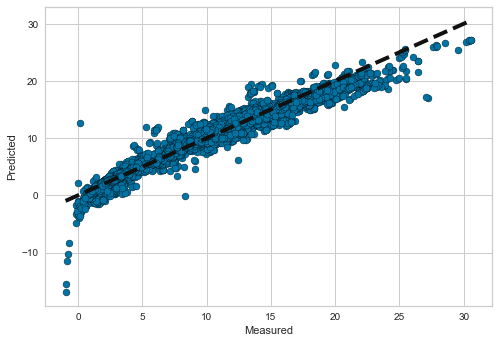

In [14]:
# Try cross=validation predict
from sklearn.model_selection import cross_val_predict
import matplotlib.pyplot as plt 


#K-fold cross-validation (with scaling test data)

# create standardizer
standardizer=StandardScaler()

# create linear regression object
ols11_1=LinearRegression()

# create a pipeline that standardizes, then runs linear regression
pipeline=make_pipeline(standardizer, ols11_1)

# create k-fold cross-validation
kf= KFold(n_splits=10, shuffle=True, random_state=1)

# conduct a k-fold cross-validation
predictedLR_S3 = cross_val_predict(pipeline, # Pipeline
                           subset3, # Feature matrix
                           y,#target vector
                           cv=kf, # Cross-validation technique
                           n_jobs = -1)

fig, ax = plt.subplots()
ax.scatter(y, predictedLR_S3, edgecolors=(0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()


**Use predictions to calculate metrics.**

In [16]:
# use predictions to do metrics
from sklearn.metrics import r2_score 
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import mean_absolute_error 
from sklearn.metrics import median_absolute_error  

# coefficient of determination r-squared R2
r2 = r2_score(y, predictedLR_S3) 
print('r-squared: %f' % r2)

# mean squared error MSE 
MSE = mean_squared_error(y, predictedLR_S3) 
print('Mean Squared Error: %f' % MSE) 

# mean absolute error MAE 
MAE = mean_absolute_error(y, predictedLR_S3) 
print('Mean Absolute Error: %f' % MAE) 

# Median absolute error MDAE 
MDAE = median_absolute_error(y, predictedLR_S3) 
print('Median Absolute Error: %f' % MDAE)   

# root mean squared error RMSE 
RMSE = np.sqrt(mean_squared_error(y, predictedLR_S3)) 
print('Root Mean Squared Error: %f' % RMSE)

r-squared: 0.963044
Mean Squared Error: 0.994081
Mean Absolute Error: 0.670680
Median Absolute Error: 0.462541
Root Mean Squared Error: 0.997036


### LASSO Linear Regression Model.

**After evaluating a regular linear regression model, I also tried a LASSO regression model in order to try to reduce features because my dataset still has many features.**

**Using all the features results in good scores.**

In [76]:
#Lasso Regression to reduce features / Cross-validation (with scaling train data)

#load libraries
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

# create standardizer
standardizer=StandardScaler()

#Create lasso regression object with alpha value
lasso = Lasso(alpha=0.5)

# create a pipeline that standardizes, then runs linear regression
pipeline=make_pipeline(standardizer, lasso)
# create k-fold cross-validation
kf= KFold(n_splits=10, shuffle=True, random_state=1)
# conduct a k-fold cross-validation
cv_results=cross_val_score(pipeline, # Pipeline
                           X, # Feature matrix
                           y,#target vector
                           cv=kf, # Cross-validation technique
                           scoring = 'r2', # Loss function
                           n_jobs = -1)
print(cv_results.mean())
print (cv_results)
print("results")


0.8222247132920115
[0.82132675 0.80976706 0.83907596 0.83892435 0.79666066 0.82579443
 0.80443859 0.83206935 0.8206535  0.83353649]
results


**Try the best subset of features to see if it improves on using all the features.**

In [18]:
#Lasso Regression to reduce features / Cross-validation (with scaling train data)

#load libraries
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

# create standardizer
standardizer=StandardScaler()

#Create lasso regression object with alpha value
lasso = Lasso(alpha=0.5)

# create a pipeline that standardizes, then runs linear regression
pipeline=make_pipeline(standardizer, lasso)
# create k-fold cross-validation
kf= KFold(n_splits=10, shuffle=True, random_state=1)
# conduct a k-fold cross-validation
cv_results=cross_val_score(pipeline, # Pipeline
                           subset3, # Feature matrix
                           y,#target vector
                           cv=kf, # Cross-validation technique
                           scoring = 'r2', # Loss function
                           n_jobs = -1)
print(cv_results.mean())
print (cv_results)
print("results")

0.9069545235339465
[0.91711858 0.91061979 0.91555531 0.91678793 0.88104725 0.91233663
 0.88638555 0.90046709 0.91429857 0.91492854]
results


## Tune Hyperparameters

**Using all the features results in great scores, and much better than without tuning the hyperparameters.**

In [78]:
# grid search in a pipeline with lasso regression (with scaling) / cross-validation

from sklearn.model_selection import GridSearchCV

# create standardizer
standardizer=StandardScaler()

#Create lasso regression object with alpha value
# Instantiate the linear regression model using default parameters.
lasso = Lasso()

# create dictionary/range of alpha values to be used to tune the hyperparameter of the model
param_lasso={'alpha': [0.005, 0.05, 0.1, 0.2, 0.3]}

# create the grid search
grid = GridSearchCV(lasso, param_lasso, cv=5, verbose=0)

# create a pipeline that standardizes, then runs linear regression
pipeline=make_pipeline(standardizer, grid)
# create k-fold cross-validation
kf= KFold(n_splits=10, shuffle=True, random_state=1)
# conduct a k-fold cross-validation
cv_results=cross_val_score(pipeline, # Pipeline
                           X, # Feature matrix
                           y,#target vector
                           cv=kf, # Cross-validation technique
                           scoring = 'r2', # Loss function
                           n_jobs = -1)
print(cv_results.mean())
print (cv_results)
print("results")

0.9630643248724535
[0.9628967  0.96262766 0.96367544 0.96588602 0.95947351 0.96394206
 0.95517969 0.9673468  0.96389104 0.96572432]
results


**Try the best subset of features to see if it improves on using all the features.**

In [19]:
# use best subset from baseline models
# grid search in a pipeline with lasso regression (with scaling) / cross-validation

from sklearn.model_selection import GridSearchCV

# create standardizer
standardizer=StandardScaler()

#Create lasso regression object with alpha value
# Instantiate the linear regression model using default parameters.
lasso = Lasso()

# create dictionary/range of alpha values to be used to tune the hyperparameter of the model
param_lasso={'alpha': [0.005, 0.05, 0.1, 0.2, 0.3]}

# create the grid search
grid = GridSearchCV(lasso, param_lasso, cv=5, verbose=0)

# create a pipeline that standardizes, then runs linear regression
pipeline=make_pipeline(standardizer, grid)
# create k-fold cross-validation
kf= KFold(n_splits=10, shuffle=True, random_state=1)
# conduct a k-fold cross-validation
cv_results=cross_val_score(pipeline, # Pipeline
                           subset3, # Feature matrix
                           y,#target vector
                           cv=kf, # Cross-validation technique
                           scoring = 'r2', # Loss function
                           n_jobs = -1)
print(cv_results.mean())
print (cv_results)
print("results")

0.9628585052867941
[0.96552559 0.96200076 0.96717758 0.96317371 0.95446767 0.96600642
 0.95545277 0.96403713 0.96400676 0.96673666]
results


**Use the tuned model to make predictions.**

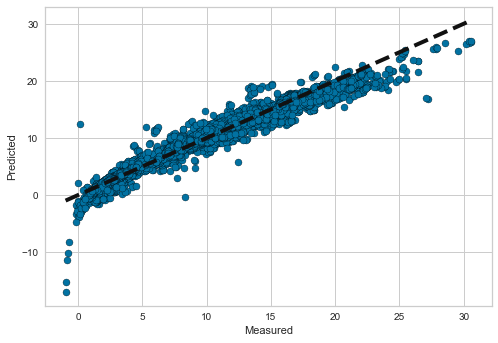

In [21]:

# Try cross_validation predict
from sklearn.model_selection import cross_val_predict
import matplotlib.pyplot as plt 

# grid search in a pipeline with lasso regression (with scaling) / cross-validation
from sklearn.model_selection import GridSearchCV

# create standardizer
standardizer=StandardScaler()

#Create lasso regression object with alpha value
# Instantiate the linear regression model using default parameters.
lasso = Lasso()

# create dictionary/range of alpha values to be used to tune the hyperparameter of the model
param_lasso={'alpha': [0.005, 0.05, 0.1, 0.2, 0.3]}

# create the grid search
grid = GridSearchCV(lasso, param_lasso, cv=5, verbose=0)

# create a pipeline that standardizes, then runs linear regression
pipeline=make_pipeline(standardizer, grid)
# create k-fold cross-validation
kf= KFold(n_splits=10, shuffle=True, random_state=1)
# conduct a k-fold cross-validation
predictLASSO_S3 = cross_val_predict(pipeline, # Pipeline
                           subset3, # Feature matrix
                           y,#target vector
                           cv=kf, # Cross-validation technique
                           n_jobs = -1)
fig, ax = plt.subplots()
ax.scatter(y, predictLASSO_S3, edgecolors=(0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()




**Use predictions to calculate metrics.**

In [22]:
# use predictions to do metrics
from sklearn.metrics import r2_score 
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import mean_absolute_error 
from sklearn.metrics import median_absolute_error  

# coefficient of determination r-squared 
r2 = r2_score(y, predictLASSO_S3) 
print('r-squared: %f' % r2) 

# mean squared error MSE 
MSE = mean_squared_error(y, predictLASSO_S3) 
print('Mean Squared Error: %f' % MSE) 

# mean absolute error MAE 
MAE = mean_absolute_error(y, predictLASSO_S3) 
print('Mean Absolute Error: %f' % MAE) 

# Median absolute error MDAE 
MDAE = median_absolute_error(y, predictLASSO_S3) 
print('Median Absolute Error: %f' % MDAE)   

# root mean squared error MSE 
RMSE = np.sqrt(mean_squared_error(y, predictLASSO_S3)) 
print('Root Mean Squared Error: %f' % RMSE)

r-squared: 0.962770
Mean Squared Error: 1.001440
Mean Absolute Error: 0.672556
Median Absolute Error: 0.466584
Root Mean Squared Error: 1.000720
